# EDA + Unified Model Benchmark (Per Sector)

This notebook follows the EDA workflow style, trains all classification models with the **same feature set** and time split, and then evaluates model behaviour **per sector**.

Models included:
- Decision Tree
- Logistic Regression
- Random Forest
- XGBoost (if installed)
- HistGradientBoostingClassifier (**new model**)

Sector feature usage:
- `Sector_encoded` is included in `FEATURE_COLS` for every model.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print('xgboost is not installed; XGBoost will be skipped.')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)


In [2]:
df = pd.read_csv('../data/merged_dataset.csv', parse_dates=['date'])
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

print(f'Shape: {df.shape}')
print(f'Date range: {df["date"].min().date()} - {df["date"].max().date()}')
print(f'Tickers: {df["ticker"].nunique():,}')
df.head(3)


Shape: (1264542, 43)
Date range: 2016-02-10 - 2026-02-09
Tickers: 503


,date,ticker,adj_close,close,high,low,open,volume,daily_return,log_return,...,Yield_Spread,Regime_GMM,Regime_label,news_count,sentiment_mean,sentiment_sum,positive_count,negative_count,neutral_count,sentiment_ratio
0,2016-02-10,A,33.100433,35.849998,36.730000,35.529999,35.630001,3170000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-02-11,A,32.620323,35.330002,35.610001,34.939999,35.119999,3224000.0,-0.014505,-0.014611,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-02-12,A,33.442055,36.220001,36.230000,35.520000,35.840000,3923600.0,0.025191,0.024879,...,0.027053,0.0,Stressful,NaN,NaN,NaN,NaN,NaN,NaN,NaN


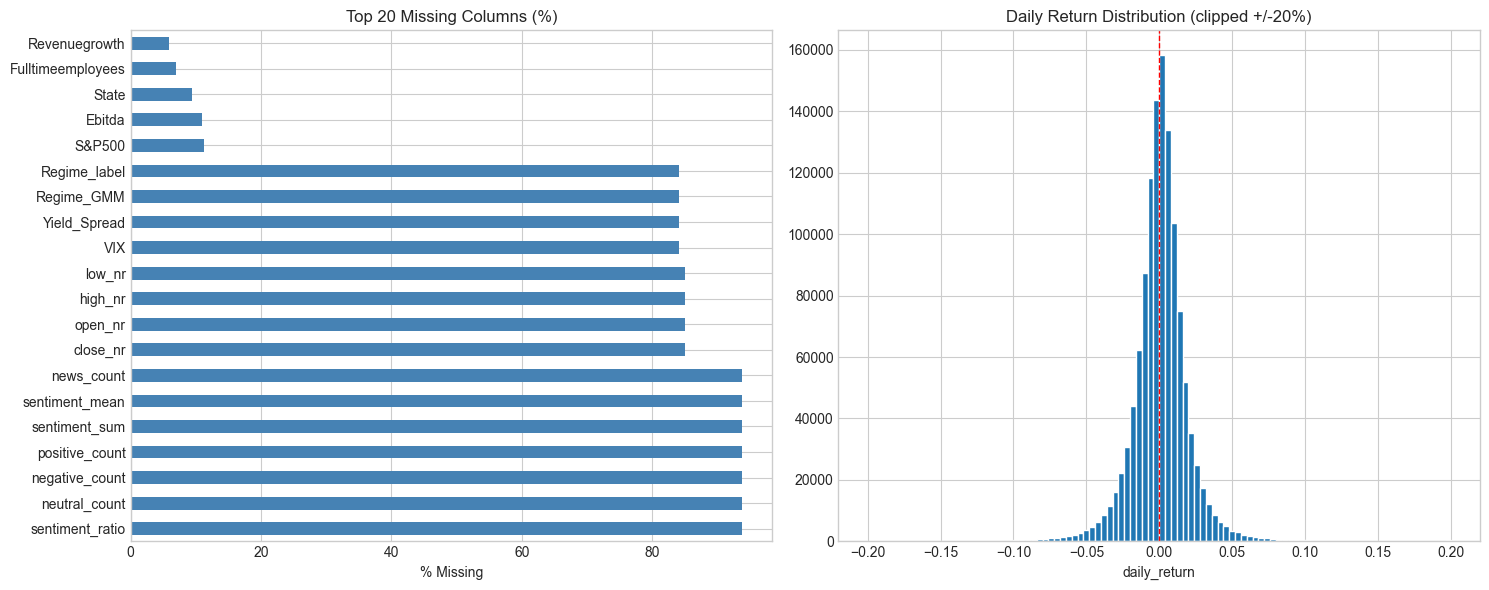

In [3]:
missing = (df.isna().mean() * 100).sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
missing[missing > 0].head(20).plot.barh(ax=axes[0], color='steelblue')
axes[0].set_title('Top 20 Missing Columns (%)')
axes[0].set_xlabel('% Missing')

df['daily_return'].dropna().clip(-0.2, 0.2).hist(bins=100, ax=axes[1], edgecolor='white')
axes[1].set_title('Daily Return Distribution (clipped +/-20%)')
axes[1].set_xlabel('daily_return')
axes[1].axvline(0, color='red', ls='--', lw=1)

plt.tight_layout()
plt.show()


## Feature Engineering (same features across all models)

In [4]:
# Target
df['next_return'] = df.groupby('ticker')['daily_return'].shift(-1)
df['target'] = (df['next_return'] > 0).astype(int)

# Lagged returns
df['lag_return_1'] = df['daily_return']
df['lag_return_2'] = df.groupby('ticker')['daily_return'].shift(1)
df['lag_return_5'] = df.groupby('ticker')['daily_return'].shift(4)

# Technical ratios
df['price_to_ma20'] = (
    df['close'] / df['rolling_mean_20'].replace(0, np.nan)
).replace([np.inf, -np.inf], np.nan) - 1

df['hl_range'] = (df['high'] - df['low']) / df['close'].replace(0, np.nan)

df['prev_close'] = df.groupby('ticker')['close'].shift(1)
df['oc_gap'] = (
    (df['open'] - df['prev_close']) / df['prev_close'].replace(0, np.nan)
).replace([np.inf, -np.inf], np.nan)

df['vol_20ma'] = df.groupby('ticker')['volume'].transform(
    lambda x: x.rolling(20, min_periods=1).mean()
)
df['vol_norm'] = (df['volume'] / df['vol_20ma'].replace(0, np.nan)).clip(0, 10)

# News and fundamentals
df['has_news'] = (df['news_count'].fillna(0) > 0).astype(float)
df['log_marketcap'] = np.log1p(df['Marketcap'].fillna(0))

# Convert potentially mixed types before imputing
for col in ['VIX', 'Yield_Spread', 'Regime_GMM', 'sentiment_mean', 'sentiment_ratio', 'Revenuegrowth', 'Weight']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Same imputation policy used in existing model notebooks
df['VIX'] = df['VIX'].fillna(df['VIX'].median())
df['Yield_Spread'] = df['Yield_Spread'].fillna(df['Yield_Spread'].median())
df['Regime_GMM'] = df['Regime_GMM'].fillna(df['Regime_GMM'].median())
df['sentiment_mean'] = df['sentiment_mean'].fillna(0)
df['sentiment_ratio'] = df['sentiment_ratio'].fillna(0)
df['Revenuegrowth'] = df['Revenuegrowth'].fillna(0)
df['Weight'] = df['Weight'].fillna(0)

df['Sector_encoded'] = df['Sector'].astype('category').cat.codes.astype(float)

FEATURE_COLS = [
    'lag_return_1', 'lag_return_2', 'lag_return_5',
    'rolling_std_20', 'price_to_ma20',
    'hl_range', 'oc_gap', 'vol_norm',
    'VIX', 'Yield_Spread', 'Regime_GMM',
    'sentiment_mean', 'sentiment_ratio', 'has_news',
    'log_marketcap', 'Revenuegrowth', 'Weight',
    'Sector_encoded',
]

model_df = df[FEATURE_COLS + ['target', 'date']].dropna()

SPLIT_DATE = '2023-01-01'
train = model_df[model_df['date'] < SPLIT_DATE]
test = model_df[model_df['date'] >= SPLIT_DATE]

X_train, y_train = train[FEATURE_COLS], train['target'].astype(int)
X_test, y_test = test[FEATURE_COLS], test['target'].astype(int)

baseline = max(y_test.mean(), 1 - y_test.mean())

print(f'Rows after dropna: {len(model_df):,}')
print(f'Train: {len(train):,} rows')
print(f'Test:  {len(test):,} rows')
print(f'Always-Up baseline: {baseline:.4f}')


Rows after dropna: 1,219,484
Train: 830,418 rows
Test:  389,066 rows
Always-Up baseline: 0.5224


In [5]:
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=19, random_state=42),
    'Logistic Regression': LogisticRegression(C=0.00163, max_iter=1000, n_jobs=-1),
    'Random Forest': RandomForestClassifier(
        n_estimators=300, max_depth=8, min_samples_leaf=200,
        max_features='sqrt', random_state=42, n_jobs=-1
    ),
    # New algorithm not used in current notebooks
    'HistGradientBoosting': HistGradientBoostingClassifier(
        learning_rate=0.05, max_iter=300, max_depth=8,
        min_samples_leaf=200, random_state=42
    ),
}

if XGB_AVAILABLE:
    models['XGBoost'] = XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, min_child_weight=50,
        reg_alpha=0.1, reg_lambda=1.0, eval_metric='logloss',
        random_state=42, n_jobs=-1, verbosity=0
    )

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

trained_models = {}
predictions = {}
rows = []

for name, model in models.items():
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train.values, y_train)
        y_pred = model.predict(X_test.values)

    trained_models[name] = model
    predictions[name] = y_pred

    acc = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    rows.append({'Model': name, 'Accuracy': acc, 'Balanced_Accuracy': bacc})

    print(f'=== {name} ===')
    print(f'Accuracy: {acc:.4f} | Balanced Accuracy: {bacc:.4f} | Baseline: {baseline:.4f}')
    print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))


=== Decision Tree ===
Accuracy: 0.5170 | Balanced Accuracy: 0.4991 | Baseline: 0.5224
              precision    recall  f1-score   support

        Down       0.47      0.10      0.16    185824
          Up       0.52      0.90      0.66    203242

    accuracy                           0.52    389066
   macro avg       0.50      0.50      0.41    389066
weighted avg       0.50      0.52      0.42    389066

=== Logistic Regression ===
Accuracy: 0.5182 | Balanced Accuracy: 0.5000 | Baseline: 0.5224
              precision    recall  f1-score   support

        Down       0.48      0.10      0.16    185824
          Up       0.52      0.90      0.66    203242

    accuracy                           0.52    389066
   macro avg       0.50      0.50      0.41    389066
weighted avg       0.50      0.52      0.42    389066

=== Random Forest ===
Accuracy: 0.5176 | Balanced Accuracy: 0.4992 | Baseline: 0.5224
              precision    recall  f1-score   support

        Down       0.47    

In [6]:
results_df = pd.DataFrame(rows).sort_values('Accuracy', ascending=False).reset_index(drop=True)
results_df


,Model,Accuracy,Balanced_Accuracy
0,Logistic Regression,0.518172,0.500045
1,HistGradientBoosting,0.518018,0.500972
2,Random Forest,0.517617,0.499190
3,XGBoost,0.517339,0.500580
4,Decision Tree,0.517018,0.499062


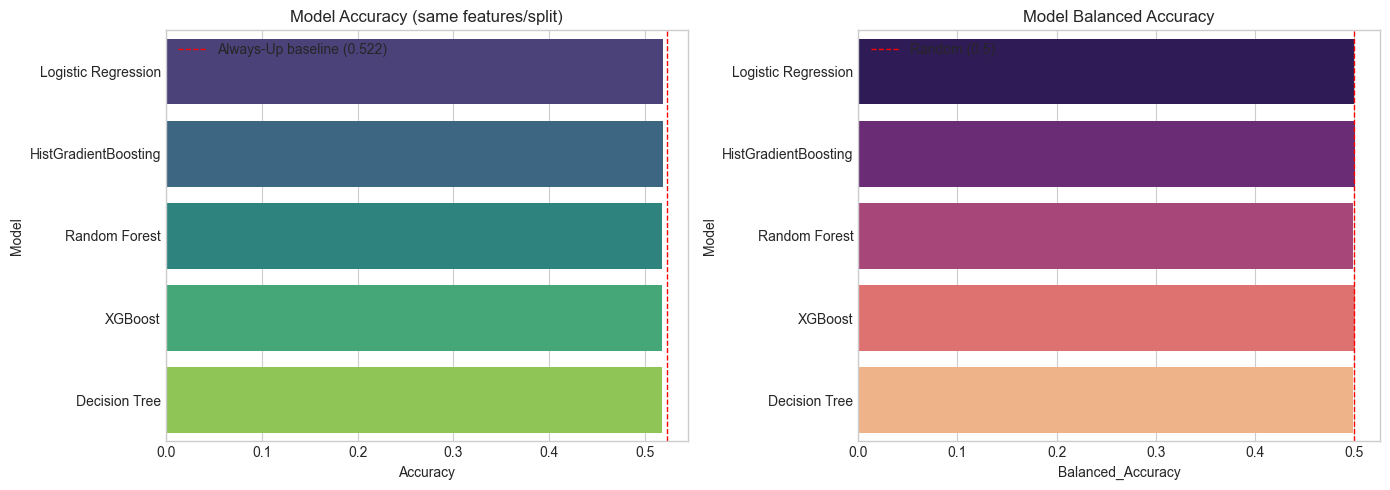

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=results_df, x='Accuracy', y='Model', palette='viridis', ax=axes[0])
axes[0].axvline(baseline, color='red', ls='--', lw=1, label=f'Always-Up baseline ({baseline:.3f})')
axes[0].set_title('Model Accuracy (same features/split)')
axes[0].legend()

sns.barplot(data=results_df, x='Balanced_Accuracy', y='Model', palette='magma', ax=axes[1])
axes[1].axvline(0.5, color='red', ls='--', lw=1, label='Random (0.5)')
axes[1].set_title('Model Balanced Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


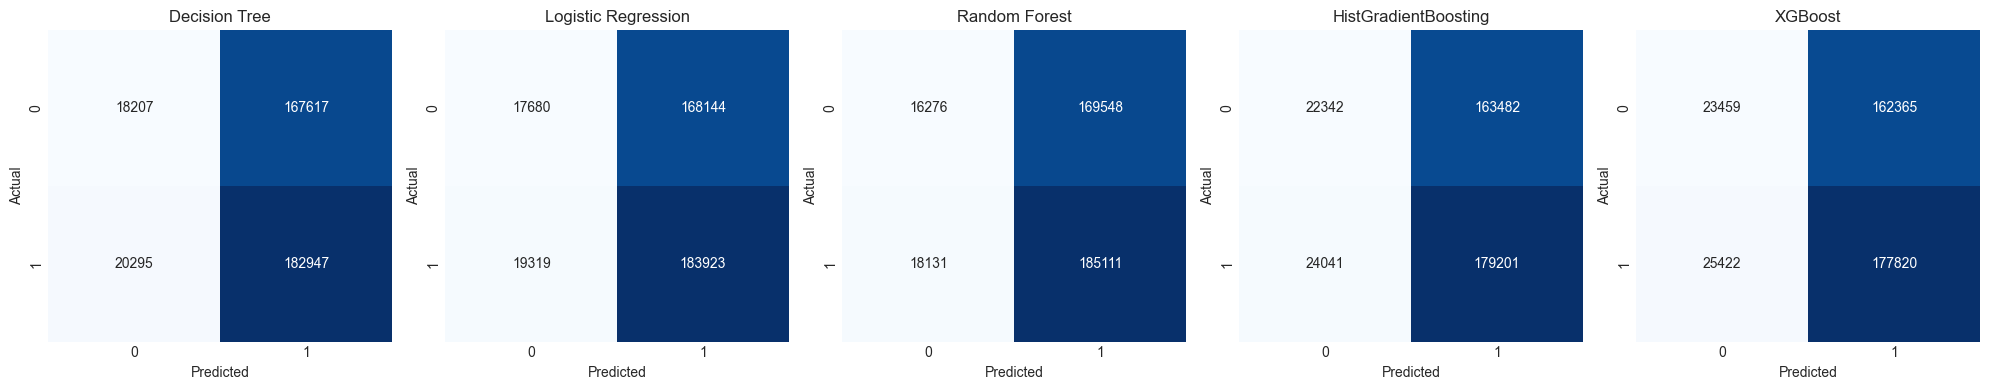

In [8]:
n_models = len(predictions)
fig, axes = plt.subplots(1, n_models, figsize=(4 * n_models, 4))
if n_models == 1:
    axes = [axes]

for ax, (name, y_pred) in zip(axes, predictions.items()):
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


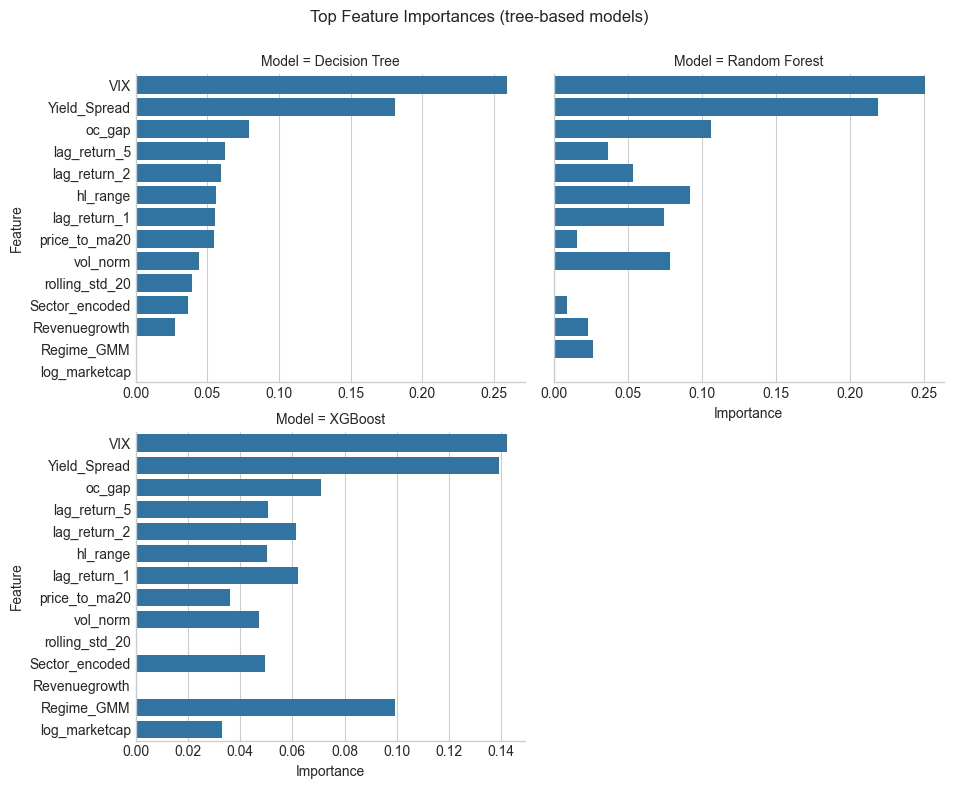

In [9]:
importance_frames = []
for name, model in trained_models.items():
    if hasattr(model, 'feature_importances_'):
        fi = pd.DataFrame({
            'Model': name,
            'Feature': FEATURE_COLS,
            'Importance': model.feature_importances_,
        }).sort_values('Importance', ascending=False).head(12)
        importance_frames.append(fi)

if importance_frames:
    fi_all = pd.concat(importance_frames, ignore_index=True)
    g = sns.catplot(
        data=fi_all, x='Importance', y='Feature', col='Model',
        kind='bar', col_wrap=2, sharex=False, height=4, aspect=1.2
    )
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('Top Feature Importances (tree-based models)')
    plt.show()
else:
    print('No feature_importances_ available in trained models.')


## Sector-Level Evaluation

The same trained models are evaluated per sector to check whether performance changes across industries.

`Sector_encoded` is already included in `FEATURE_COLS`, so sector information is used during training.

In [ ]:
sector_series = df.loc[model_df.index, 'Sector'].fillna('Unknown').astype(str)
test_sector = sector_series.loc[test.index]

print(f'Unique sectors in test set: {test_sector.nunique()}')
print(sorted(test_sector.unique().tolist()))


In [ ]:
def _safe_recall(y_true, y_pred, label):
    mask = (y_true == label)
    denom = mask.sum()
    if denom == 0:
        return np.nan
    return ((y_pred == label) & mask).sum() / denom

sector_rows = []

for model_name, y_pred in predictions.items():
    eval_df = pd.DataFrame({
        'Sector': test_sector.values,
        'y_true': y_test.values,
        'y_pred': y_pred,
    })

    for sector, g in eval_df.groupby('Sector'):
        acc = accuracy_score(g['y_true'], g['y_pred'])
        bacc = balanced_accuracy_score(g['y_true'], g['y_pred'])
        down_recall = _safe_recall(g['y_true'].values, g['y_pred'].values, 0)
        up_recall = _safe_recall(g['y_true'].values, g['y_pred'].values, 1)
        sector_baseline = max(g['y_true'].mean(), 1 - g['y_true'].mean())

        sector_rows.append({
            'Model': model_name,
            'Sector': sector,
            'N': len(g),
            'Accuracy': acc,
            'Balanced_Accuracy': bacc,
            'Down_Recall': down_recall,
            'Up_Recall': up_recall,
            'Sector_Baseline': sector_baseline,
            'Delta_vs_Sector_Baseline': acc - sector_baseline,
        })

sector_results_df = pd.DataFrame(sector_rows).sort_values(['Model', 'Accuracy'], ascending=[True, False])
sector_results_df.head(30)


In [ ]:
best_by_sector = (
    sector_results_df.loc[sector_results_df.groupby('Sector')['Accuracy'].idxmax()]
    .sort_values('Accuracy', ascending=False)
    [['Sector', 'Model', 'N', 'Accuracy', 'Balanced_Accuracy', 'Sector_Baseline', 'Delta_vs_Sector_Baseline']]
    .reset_index(drop=True)
)

best_by_sector


In [ ]:
acc_pivot = sector_results_df.pivot(index='Sector', columns='Model', values='Accuracy')
acc_pivot = acc_pivot.loc[acc_pivot.mean(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(12, 6))
sns.heatmap(acc_pivot, annot=True, fmt='.3f', cmap='YlGnBu')
plt.title('Per-Sector Accuracy by Model')
plt.ylabel('Sector')
plt.xlabel('Model')
plt.tight_layout()
plt.show()


In [ ]:
delta_pivot = sector_results_df.pivot(index='Sector', columns='Model', values='Delta_vs_Sector_Baseline')
delta_pivot = delta_pivot.loc[delta_pivot.mean(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(12, 6))
sns.heatmap(delta_pivot, annot=True, fmt='.3f', cmap='RdBu_r', center=0)
plt.title('Accuracy Delta vs Sector Baseline (positive is better)')
plt.ylabel('Sector')
plt.xlabel('Model')
plt.tight_layout()
plt.show()


In [ ]:
results_df.to_csv('../data/model_overall_results.csv', index=False)
sector_results_df.to_csv('../data/model_sector_results.csv', index=False)
best_by_sector.to_csv('../data/model_best_by_sector.csv', index=False)

print('Saved: ../data/model_overall_results.csv')
print('Saved: ../data/model_sector_results.csv')
print('Saved: ../data/model_best_by_sector.csv')
